In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [2]:
import tensorflow as tf
from tensorflow.python import keras
import numpy 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D
from tensorflow.keras.layers import Activation, Flatten, Dense, Dropout, Input, BatchNormalization
from tensorflow.keras.layers import Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.datasets import cifar10
from tensorflow.python.keras.utils import np_utils
import matplotlib.pyplot as plt

from keras.regularizers import l2
#from keras.callbacks import LearningRateScheduler

Using TensorFlow backend.


In [3]:
#fix random seed for reproducibility
seed= 1234
numpy.random.seed(seed)

# load minit data
(X_train, y_train),(X_test, y_test) = cifar10.load_data()


X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
'''
rescaled the image data below so that each pixel lies in the interval [0, 1] instead of [0, 255].
'''
# Normalization
X_train /= 255.0
X_test /= 255.0
#print(X_train[0])

'''
encode the labels i.e. Y_train and Y_test. 
In one-hot encoding an integer is converted to an array which contains only 
one ‘1’ and the rest elements are ‘0’.
'''
# one-hot
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
print('Shape of y-train(One-hot)', y_train.shape)
print('Shape of y-test(One-hot)',y_test.shape)

170500096/170498071 [==============================] - 6s 0us/step
Shape of y-train(One-hot) (50000, 10)
Shape of y-test(One-hot) (10000, 10)


In [0]:
# ResNet-20
depth = 20

# Number of Classes
num_classes = 10

def resnet_layer(inputs, num_filters=14, kernel_size=3, strides=1, activation='relu', batch_normalization=True, conv_first=True):
    """
    2D convolution batch-normalization-activation stack builder
    Arguments
        inputs: input tensor from input image or prev layer
        num_filters: conv2D number of filters
        kernel_size: conv2D square kernel dimensions
        strides: conv2D square stride dimensions
        activation: activation name
        batch_normalization: to include batch_normalization or not
        conv_first: order of convolution
    Returns
        x: tensor as input to next layer
    """

    conv = Conv2D(num_filters, kernel_size=kernel_size, strides=strides, padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(1e-4))

    x = inputs

    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)

    return x

def resnet_model(input_shape, depth, num_classes):
    """
    resnet model builder
    Arguments
        input_shape: shape of the input image tensor
        depth: number of core convolutional layers
        num_classes: number of classes
    Returns
        model: Keras model instance
    """

    num_filters = 14
    num_res_blocks = int((depth - 2) / 9)

    inputs = Input(shape=input_shape)
    x = resnet_layer(inputs=inputs)

    # instantiate the stack of residual units
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:  # for first layer but not first stack
                strides = 2  # downsample
            y = resnet_layer(inputs=x,
                            num_filters=num_filters,
                            strides=strides)
            y = resnet_layer(inputs=y,
                            num_filters=num_filters,
                            activation=None)
            if stack > 0 and res_block == 0:  # for first layer but not first stack
                # linear projection residual shortcut connection to match changed dims
                x = resnet_layer(inputs=x,
                                num_filters=num_filters,
                                kernel_size=1,
                                strides=strides,
                                activation=None,
                                batch_normalization=False)
            x = keras.layers.add([x, y])
            x = Activation('relu')(x)
        num_filters *= 2
        
        # add classifier on top
    x = AveragePooling2D(pool_size=(2,2))(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # instantiate model
    model = Model(inputs=inputs, outputs=outputs)

    return model


In [5]:
# input image dimensions
input_shape = (32,32,3)

model = resnet_model(input_shape=input_shape, depth=depth, num_classes=10)

model.summary()


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 14)   392         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 14)   56          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 32, 32, 14)   0           batch_normalization[0][0]        
_____________

In [0]:
#from tensorflow.python.keras.optimizers import Adam
from tensorflow.keras import optimizers

sgd = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)

model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy']) #

In [7]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=15, batch_size=32, shuffle=True, ) #callbacks=[learn_rate_scheduler]

Train on 50000 samples, validate on 10000 samples
Epoch 1/15
50000/50000 [==============================] - 43s 853us/sample - loss: 1.7160 - acc: 0.4228 - val_loss: 1.5060 - val_acc: 0.4930
Epoch 2/15
50000/50000 [==============================] - 35s 710us/sample - loss: 1.3827 - acc: 0.5400 - val_loss: 1.2983 - val_acc: 0.5707
Epoch 3/15
50000/50000 [==============================] - 36s 716us/sample - loss: 1.2346 - acc: 0.5957 - val_loss: 1.2346 - val_acc: 0.5953
Epoch 4/15
50000/50000 [==============================] - 36s 719us/sample - loss: 1.1249 - acc: 0.6379 - val_loss: 1.2048 - val_acc: 0.6060
Epoch 5/15
50000/50000 [==============================] - 35s 707us/sample - loss: 1.0412 - acc: 0.6678 - val_loss: 1.1828 - val_acc: 0.6249
Epoch 6/15
50000/50000 [==============================] - 35s 702us/sample - loss: 0.9696 - acc: 0.6942 - val_loss: 1.1068 - val_acc: 0.6488
Epoch 7/15
50000/50000 [==============================] - 35s 704us/sample - loss: 0.9114 - acc: 0.7143 

In [0]:
score = model.evaluate(X_test, y_test, verbose=0)

In [9]:
print("Accuracy on test set: ",score[1])

Accuracy on test set:  0.7009


In [10]:
model.metrics_names


['loss', 'acc']

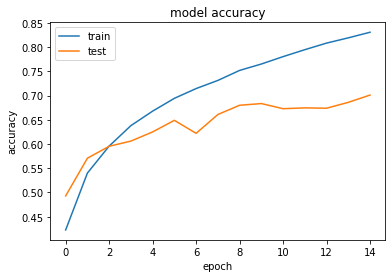

In [12]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

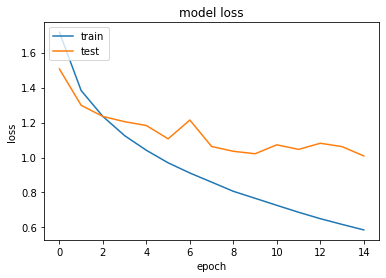

In [13]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()